In [3]:
#%pip install numpy
#%pip install pandas
#%pip install pickle
#%pip install ipywidgets
#%pip install matplotlib
import numpy as np
import pandas as pd
import pickle
from ipywidgets import interact
import matplotlib.pyplot as plt
#%pip install pyarrow
##%pip install fastparquet

### J'ai des pb avec lire les pickles sur mon google drive donc je laisse de téco pr l'instant


In [4]:
df0 = pd.read_parquet('pass0.parquet')
df1 = pd.read_parquet('pass1.parquet')

In [5]:
print(list(df0))
df0.head()

['IRI_mean', 'IRI_sequence', 'GM.TS_or_Distance', 'GM.T', 'GM.lat_int', 'GM.lon_int', 'GM.acc.xyz.z', 'GM.acc.xyz.y', 'GM.acc.xyz.x', 'GM.obd.spd_veh.value']


,IRI_mean,IRI_sequence,GM.TS_or_Distance,GM.T,GM.lat_int,GM.lon_int,GM.acc.xyz.z,GM.acc.xyz.y,GM.acc.xyz.x,GM.obd.spd_veh.value
0,4.933540,"[6.644882798499999, 5.5573473115, 7.666319952,...","[2021-04-22T01:21:54.349000000, 2021-04-22T01:...","[acc.xyz, acc.xyz, acc.xyz, acc.xyz, obd.spd_v...","[55.654713308383236, 55.65471373053892, 55.654...","[12.486686901197604, 12.486686532934131, 12.48...","[0.9727, 0.9727, 0.9727, 0.9727, 0.9922, 0.992...","[-0.1172, -0.1172, -0.1172, -0.1172, -0.1211, ...","[0.1602, 0.1602, 0.1602, 0.1602, 0.1563, 0.156...","[31.04, 31.0, 30.970000000000002, 31.470000000..."
1,4.696225,"[5.5573473115, 7.666319952, 4.1605364705, 5.35...","[2021-04-22T01:21:55.068000000, 2021-04-22T01:...","[acc.xyz, acc.xyz, acc.xyz, acc.xyz, acc.xyz, ...","[55.654781462897525, 55.65478160070671, 55.654...","[12.48662899293286, 12.486628876325089, 12.486...","[0.9727, 0.9727, 0.9727, 0.9727, 0.9727, 0.972...","[-0.0898, -0.0898, -0.0898, -0.0898, -0.0898, ...","[0.1406, 0.1406, 0.1406, 0.1406, 0.1406, 0.140...","[29.52, 29.48, 29.42, 29.400000000000002, 29.3..."
2,4.699145,"[7.666319952, 4.1605364705, 5.359907053000001,...","[2021-04-22T01:21:56.327000000, 2021-04-22T01:...","[acc.xyz, acc.xyz, acc.xyz, acc.xyz, acc.xyz, ...","[55.654862308917195, 55.65486260509554, 55.654...","[12.486560579617835, 12.486560331210192, 12.48...","[1.0391, 1.0391, 1.0391, 1.0391, 1.0391, 1.015...","[0.0273, 0.0273, 0.0273, 0.0273, 0.0273, 0.011...","[0.1523, 0.1523, 0.1523, 0.1523, 0.1523, 0.160...","[30.080000000000002, 30.14, 30.2, 30.23, 29.54..."
3,4.397566,"[4.1605364705, 5.359907053000001, 4.5512844555...","[2021-04-22T01:21:57.983000000, 2021-04-22T01:...","[acc.xyz, acc.xyz, acc.xyz, acc.xyz, acc.xyz, ...","[55.654942544169614, 55.65494265017668, 55.654...","[12.486492964664311, 12.486492879858657, 12.48...","[1.0391, 1.0391, 0.9805, 0.9805, 0.9805, 0.980...","[0.1016, 0.1016, 0.0898, 0.0898, 0.0898, 0.089...","[0.2188, 0.2188, 0.1953, 0.1953, 0.1953, 0.195...","[36.910000000000004, 37.0, 37.07, 37.18, 37.25..."
4,4.400549,"[5.359907053000001, 4.5512844555, 5.8527534034...","[2021-04-22T01:21:59.120000000, 2021-04-22T01:...","[obd.spd_veh, acc.xyz, acc.xyz, acc.xyz, acc.x...","[55.65502238338658, 55.65502269329073, 55.6550...","[12.486424923322684, 12.486424661341852, 12.48...","[0.9492, 0.9961, 0.9961, 0.9961, 0.9961, 0.996...","[0.0859, 0.0977, 0.0977, 0.0977, 0.0977, 0.097...","[0.1875, 0.1563, 0.1563, 0.1563, 0.1563, 0.156...","[41.2, 41.27, 41.38, 41.46, 41.53, 40.76, 41.6..."


In [6]:
def show(col):
    try:
        plt.hist(df0[col].map(len), bins=20)
        plt.show()
        plt.plot(df0.loc[0,col])
    except:
        ...#reeee
    
interact(show, col=list(df0));

interactive(children=(Dropdown(description='col', options=('IRI_mean', 'IRI_sequence', 'GM.TS_or_Distance', 'G…

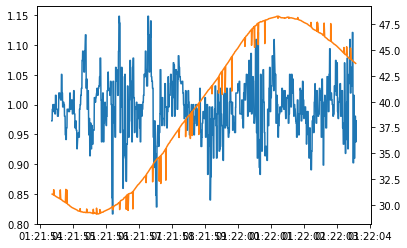

In [7]:
s0 = df0.loc[0]
mask = s0['GM.T'] == 'acc.xyz'
accT = s0['GM.TS_or_Distance'][mask]
accZ = s0['GM.acc.xyz.z']
obdT = s0['GM.TS_or_Distance'][~mask]
obd = s0['GM.obd.spd_veh.value']

# plt.plot(accZ)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(accT, accZ, color='#1f77b4')
ax2.plot(obdT, obd, color='#ff7f0e');

# weird stuff on the orange curve (?)

In [110]:
from torch.utils.data import Dataset

class MyDS(Dataset):
    def __init__(self, fname, size=None):
        df = fname
        zacc = df['GM.acc.xyz.z'] # Series[arr[:]float]
        
        if not size:
            size = zacc.map(len).quantile(.1)
            size = (int(size) // 32) * 32
        self.sz = size
        zacc = zacc[zacc.map(len) >= size]
        
        def truncate(arr):
            return arr[:size]
        zacc = np.stack(zacc.map(truncate)).astype('float32')
        # print(zacc.shape, size)
        self.zacc = zacc
        
    
    def __getitem__(self, idx):
        return self.zacc[idx][None,:]
    
    def __len__(self):
        return len(self.zacc)

L = 2048
my_data = MyDS(df0, L) #size = N

In [289]:
import torch
import torch.nn as nn 

class AE(nn.Module):
    def __init__(self, hidden_units, num_features, L,latent_features=3):
        super().__init__()
        
        mid = L // (4*4*4) #latent space dims
        assert L % (4*4*4) == 0
        
        self.encoder = nn.Sequential(
            
            nn.LSTM(input_size =num_features, hidden_size =hidden_units),
            nn.ReLU(),
            # bottleneck layer
            nn.Linear(in_features=hidden_units, out_features=latent_features)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=hidden_units),
            nn.ReLU(),
            # output layer, projecting back to image size
            nn.LSTM(input_size =hidden_units, hidden_size =num_features)
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        # print(encoded.shape)
        decoded = self.decoder(encoded)
        return decoded
        
    def get_latent(self,x):
        return self.encoder(x)

In [55]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )
    def forward(self, x):
        #x = x.reshape((1, self.seq_len, self.n_features))
        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        return hidden_n#.reshape((self.n_features, self.embedding_dim))

    def get_latent(self,x):
        return self.encoder(x)

In [56]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features
        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.output_layer = nn.Linear(self.hidden_dim, n_features)
    def forward(self, x):
        #x = x.repeat(self.seq_len, self.n_features)
        #x = x.reshape((self.n_features, self.seq_len, self.input_dim))
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        #x = x.reshape((self.seq_len, self.hidden_dim))
        return self.output_layer(x)

In [57]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()
        self.encoder = Encoder(seq_len, n_features, embedding_dim)
        self.decoder = Decoder(seq_len, embedding_dim, n_features)
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    def get_latent(self,x):
        return self.encoder(x)

In [58]:
def visualization(x,display = True):
    tsne = TSNE(n_components=2, n_iter=3000, )
    vis = tsne.fit_transform(x)
    if display:
        fig, ax = plt.subplots()
        ax.scatter(*vis.T)
        plt.show()
    else:
        return vis

In [59]:
model = RecurrentAutoencoder(hidden_units, num_features,64)
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(2048, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=128, out_features=2048, bias=True)
  )
)

In [98]:
from torch.utils.data import DataLoader
#in_channels = 
#out_channels = 
#kernel_size= 
num_features = L
hidden_units = 248
n_features =10
dataloader = DataLoader(my_data, shuffle=True)
do_run = False
do_run = True
if (do_run):
    #model = AE(hidden_units,num_features,L)

    model = RecurrentAutoencoder(hidden_units, num_features, n_features)

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

    loss_array = []
    pred_array = []
    real = []
    for x in dataloader:
        real.append(x)
        pred = model(x)
        loss = loss_fn(pred, x)

        #optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_array.append(float(loss))
        pred_array.append(pred)        
        print(float(loss))

1.0022493600845337
1.0045866966247559
1.00984787940979
1.007738709449768
0.9829580783843994
1.0149180889129639
1.0229859352111816
1.0187410116195679
1.014254093170166
0.9858468770980835
1.0139307975769043
1.0037089586257935
1.0117093324661255
1.0199010372161865
0.9992226362228394
0.9921541810035706
1.0153096914291382
1.0294249057769775
1.0107002258300781
1.0113896131515503
1.0137698650360107
0.9945281744003296
1.0141916275024414
1.012922763824463
1.0061653852462769
1.005481481552124
1.0101964473724365
1.024396538734436
1.0019012689590454
1.003057837486267
1.0062237977981567
0.9947332143783569
1.0083943605422974
1.0062240362167358
1.0158261060714722
0.9913122057914734
1.0050654411315918
1.0094447135925293
1.0097105503082275
1.0045490264892578
1.0128767490386963
1.0045344829559326
1.0012072324752808
1.0128886699676514
0.9873672127723694
1.0014978647232056
1.0128666162490845
0.9951337575912476
0.9825374484062195
1.0029586553573608
1.0024429559707642
1.017735242843628
1.010353684425354
1.0

0.7548366785049438
0.7602643966674805
0.7457187175750732
0.7430375814437866
0.7448001503944397
0.7548145651817322
0.7543171644210815
0.7481262683868408
0.7395026683807373
0.750594973564148
0.7466917634010315
0.7488769888877869
0.7394365072250366
0.746941089630127
0.7471022605895996
0.7396306991577148
0.7492395639419556
0.7386807203292847
0.7318681478500366
0.7457786798477173
0.7126013040542603
0.7353017330169678
0.7385523319244385
0.7392751574516296
0.7513594627380371
0.7383898496627808
0.7273154258728027
0.7370855808258057
0.7271133661270142
0.7384204268455505
0.7329632043838501
0.723911464214325
0.7330306172370911
0.719667375087738
0.7306024432182312
0.6940225958824158
0.7260167598724365
0.7139514684677124
0.7253550887107849
0.7107834219932556
0.7262927889823914
0.7233819365501404
0.715294361114502
0.7140289545059204
0.7169273495674133
0.6947150230407715
0.7119812369346619
0.7117420434951782
0.7126927375793457
0.6947584748268127
0.6948995590209961
0.7187490463256836
0.707912325859069

0.2360554188489914
0.225544273853302
0.2381497621536255
0.23692727088928223
0.23274332284927368
0.2249295711517334
0.23043394088745117
0.2220209687948227
0.2203444391489029
0.23208492994308472
0.22655050456523895
0.21961092948913574
0.22060810029506683
0.2051866054534912
0.22202062606811523
0.22025147080421448
0.2172255516052246
0.20868079364299774
0.20959144830703735
0.21136951446533203
0.21234476566314697
0.20442095398902893
0.19908665120601654
0.21201618015766144
0.19940543174743652
0.2044648826122284
0.19554747641086578
0.2098735272884369
0.1939619779586792
0.19785694777965546
0.1896733194589615
0.2017614245414734
0.193954199552536
0.1912502497434616
0.19341006875038147
0.19016432762145996
0.18806083500385284
0.19374172389507294
0.18877889215946198
0.1881355345249176
0.18176184594631195
0.18565633893013
0.18438521027565002
0.1892377734184265
0.1811593919992447
0.1753242164850235
0.17693307995796204
0.17943637073040009
0.16974836587905884
0.1670161485671997
0.17712867259979248
0.168

0.10547658801078796
0.10653678327798843
0.1072293147444725
0.10592903196811676
0.11144871264696121
0.1227107048034668
0.1077655777335167
0.11192009598016739
0.12133491039276123
0.11677157878875732
0.11435146629810333
0.11118140816688538
0.11671699583530426
0.11964357644319534
0.11753338575363159
0.12035922706127167
0.13256490230560303
0.12229151278734207
0.12001059204339981
0.12749099731445312
0.12422706186771393
0.1261795312166214
0.13018833100795746
0.1384640783071518
0.14219990372657776
0.14839458465576172
0.13784082233905792
0.1339631974697113
0.13715803623199463
0.13388772308826447
0.14054083824157715
0.13365909457206726
0.14034312963485718
0.13891565799713135
0.13806460797786713
0.14240609109401703
0.14498324692249298
0.1535159945487976
0.14450931549072266
0.14914970099925995
0.15445971488952637
0.1534251570701599
0.1532980352640152
0.15496698021888733
0.15634118020534515
0.15266647934913635
0.16379103064537048
0.1580967903137207
0.15690748393535614
0.16735951602458954
0.16013786

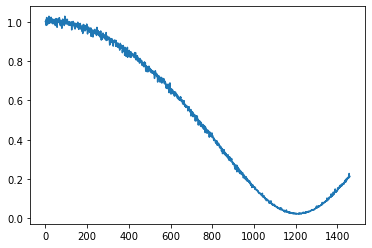

In [99]:
if (do_run):
    steps_plot = np.arange(0,len(loss_array),1)

    plt.plot(steps_plot,loss_array)
    plt.show()

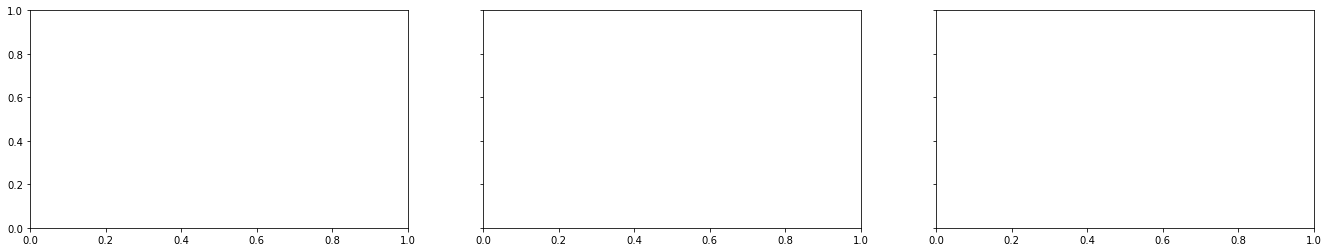

In [152]:
fig, ax = plt.subplots(
  nrows=1,
  ncols=3,
  sharey=True,
  sharex=True,
  figsize=(23, 4)
)


In [153]:
print(real[0].detach().numpy()[0][0])
print(pred_array[0].detach().numpy()[0][0])

[0.9727 0.9766 0.9766 ... 1.     1.     1.    ]
[ 0.03773585 -0.1315782  -0.03669941 ...  0.04793061  0.03217089
 -0.11594743]


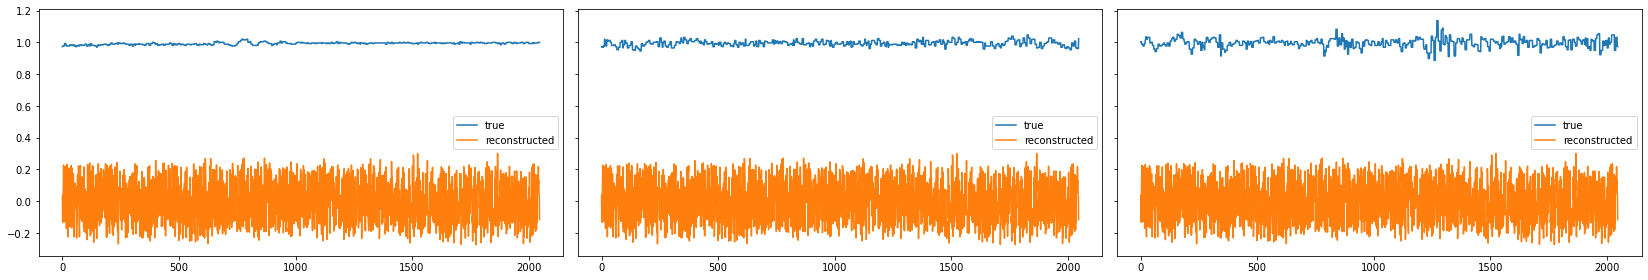

In [154]:
for i in range(3):
    ax[i].plot(real[i].detach().numpy()[0][0], label='true')
    ax[i].plot(pred_array[i].detach().numpy()[0][0] , label='reconstructed')
    #ax[i].set_title('plot (loss: {np.around(pred_losses[0], 2)})')
    ax[i].legend()
fig.tight_layout()
fig